# Importing major libraries

In [35]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from scipy import signal
import warnings as wr
from typing import Dict, List, Tuple, Optional
wr.filterwarnings('ignore')

# Importing the dataset for both Good and Bad Wind Turbine

In [37]:
df1 = pd.read_csv('batch_121219_combined.csv',low_memory=False)
df2 = pd.read_csv('batch_199672_combined.csv',low_memory=False)

# Cleaning the dataset 

In [39]:
# Cleaning the dataset
num_re = re.compile(r'[^0-9eE\+\-\.]')
def to_float(s: pd.Series) -> pd.Series:
    ''' to_float is a helper function to convert dtype from string to a float 
    Input: panda series
    Output: pandas series of dtype -> Float'''
    
    if s.dtype.kind in "fiu":  # This will not make any changes to columns which are already float
        return s.astype(float)
    s2 = s.astype(str).str.strip() # The object type columns will be modified using following logic
    s2 = s2.str.replace(',', '.', regex=False)
    s2 = s2.apply(lambda x: num_re.sub('', x))
    return pd.to_numeric(s2, errors='coerce')

# Cleaning the time column and converting the rest of the to float 
def clean_df(df: pd.DataFrame, interpolate: bool = False) -> pd.DataFrame:
    ''' Function to clean the dataset using to_float helper function, also handling the 
    missing values via linear interpolation'''
    
    clean = df.copy()
    if 't' in clean.columns:
        ts = pd.to_datetime(clean['t'], errors='coerce') # Converts the timestamps to Time Dela
        clean['t'] = ts.dt.tz_localize(None) 
    for col in clean.columns:
        if col == 't':
            continue
        if col.startswith(('B1_', 'B2_', 'B3_')):
            clean[col] = to_float(clean[col])
    if interpolate:
        num_cols = [c for c in clean.columns if c != 't']
        clean[num_cols] = clean[num_cols].interpolate(method='linear', limit_direction='both')
    return clean


In [40]:
# Cleaned dataset
T1 = clean_df(df1,True) # This dataset corresponds to turbine to 1
T2 = clean_df(df2,True) # This dataset corresponds to turbine to 2

In [41]:
T1.to_csv('Turbine_1.csv', index=False) 
T2.to_csv('Turbine_2.csv', index=False) 

## Checking for Aliasing and Leakage Issues.

In [43]:

'''Since the number of instances where the difference between two consecutive timestamps is not constant
is just two, so the concern related to aliasing and leakages is ignored'''

delta_t_1 = (T1['t'].diff().iloc[1:] == pd.Timedelta(milliseconds=16))
delta_t_2 = (T2['t'].diff().iloc[1:] == pd.Timedelta(milliseconds=16))

if delta_t_1.sum() == len(T1)-1 and delta_t_2.sum() == len(T2)-1:
    print("Time Stamps are equally spaced")
else:
    print("Time Stamps are not equally spaced")
    print(f"Number of instance where time differce for Turbine 1 is not constant: {len(T1)-1 -delta_t_1.sum()}")
    print(f"Number of instance where time differce for Turbine 2 is not constant: {len(T2)-1 -delta_t_2.sum()}")

Time Stamps are not equally spaced
Number of instance where time differce for Turbine 1 is not constant: 0
Number of instance where time differce for Turbine 2 is not constant: 2


In [44]:
# Calculating the Speed Turbine using STFT

In [45]:
def stft_onep_track(x: np.ndarray, fs: float,) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    STFT-based 1P ridge tracking on a single channel (use flap tip by default).
    Returns (t_stft, f_stft, onep_hz_t)
    """
    nperseg = int(round(stft_win_sec*fs))
    noverlap = int(round(stft_overlap*nperseg))
    f, t, Zxx = signal.stft(x, fs=fs, nperseg=nperseg, noverlap=noverlap, window="hann", detrend=False)
    # Limit to low band
    band = (f >=onep_min_hz) & (f <=onep_max_hz)
    f_b = f[band]
    Z_b = Zxx[band, :]
    P_b = np.abs(Z_b)**2
    # Pick dominant peak per time slice
    idx = np.argmax(P_b, axis=0)  # (time,)
    onep_track = f_b[idx]
    return t, f_b, onep_track


def median_filter(x: np.ndarray, k: int) -> np.ndarray:
    if k < 3 or k % 2 == 0:
        return x
    return signal.medfilt(x, kernel_size=k)
    
def rpm_from_onep(onep_hz: np.ndarray) -> np.ndarray:
    return 60.0 * onep_hz

In [46]:
fs = 62.5
stft_win_sec = 10.0          # long enough to resolve <2 Hz
stft_overlap = 0.75
onep_max_hz = 2.0            # cap 1P search below this
onep_min_hz = 0.05
rpm_medfilt_len = 2           # median filter window 

ch_names = []
axes = ["edge", "span", "flap"]
blade = [1]
for i in blade:
    for loc in ["root", "tip"]:
        for ax in axes:
            name = f"B{i}_{loc}_{ax}"
            ch_names.append(name)

In [47]:
T1_speed = {}
T2_speed = {}
T1_speed_sm = {}
T2_speed_sm ={}
t_stft = None
for i in ch_names:
    x = T1[i].to_numpy(dtype=float)
    y = T2[i].to_numpy(dtype=float)
    t_stft, f_band, onep_track = stft_onep_track(x,fs)
    rpm_raw = rpm_from_onep(onep_track)
    rpm_sm = median_filter(rpm_raw,rpm_medfilt_len)
    T1_speed[i] = rpm_raw
    T1_speed_sm[i] = rpm_sm
    t_stft, f_band, onep_track = stft_onep_track(y,fs)
    rpm_raw = rpm_from_onep(onep_track)
    rpm_sm = median_filter(rpm_raw,rpm_medfilt_len)
    T2_speed[i] = rpm_raw
    T2_speed_sm[i] = rpm_sm
    t_stft = t_stft

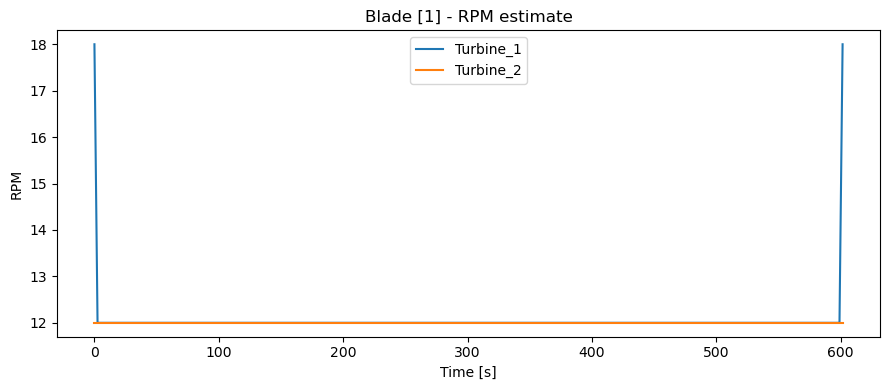

In [48]:
plt.figure(figsize=(9,4))
plt.plot(t_stft, T1_speed['B1_root_edge'], label="Turbine_1")
plt.plot(t_stft, T2_speed['B1_root_edge'], label="Turbine_2")
plt.xlabel("Time [s]"); plt.ylabel("RPM"); plt.title(f"Blade {blade} - RPM estimate")
plt.legend(); plt.tight_layout()

# Creating windows, then calculating Mean and RMS for each Channel in the Dataset

## Turbine 1

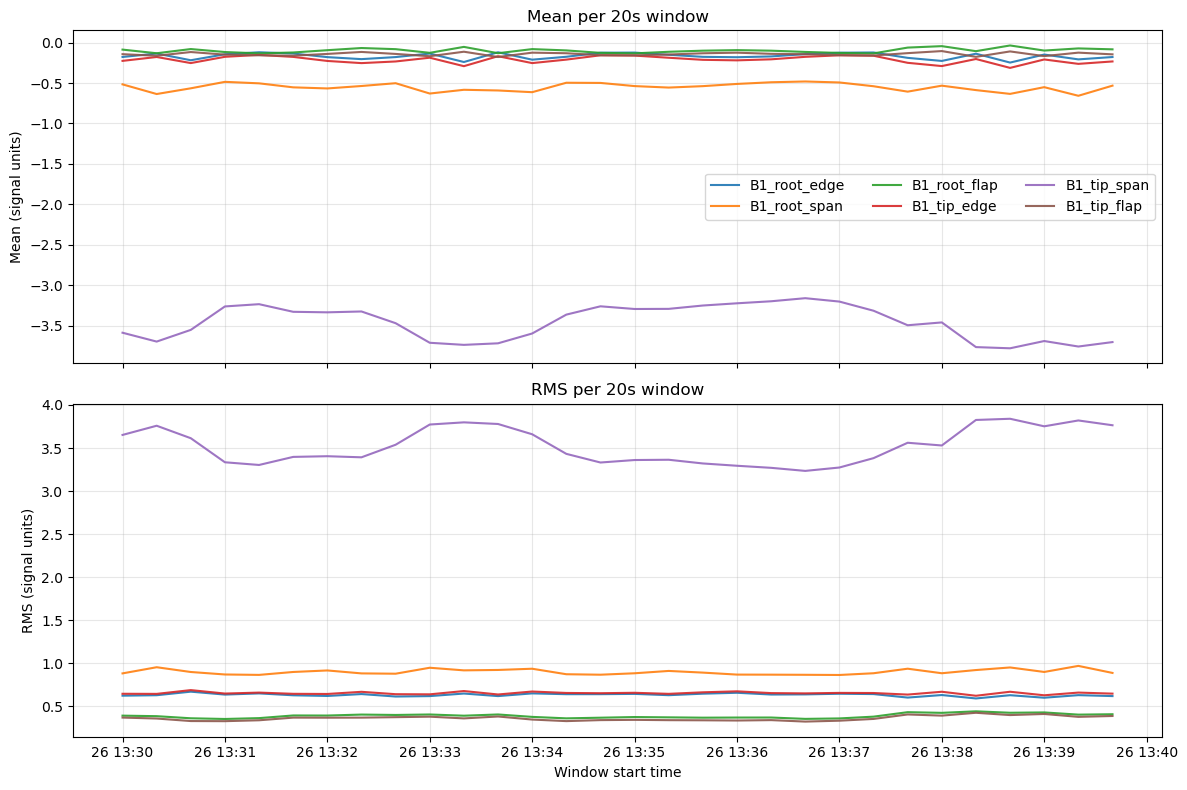

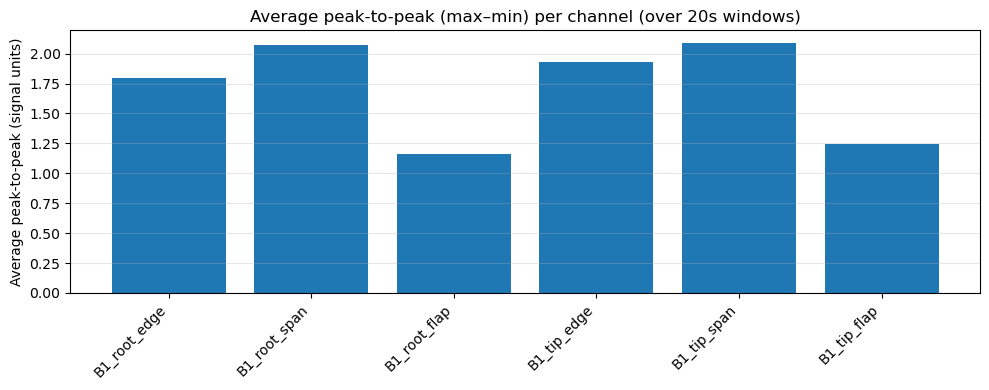

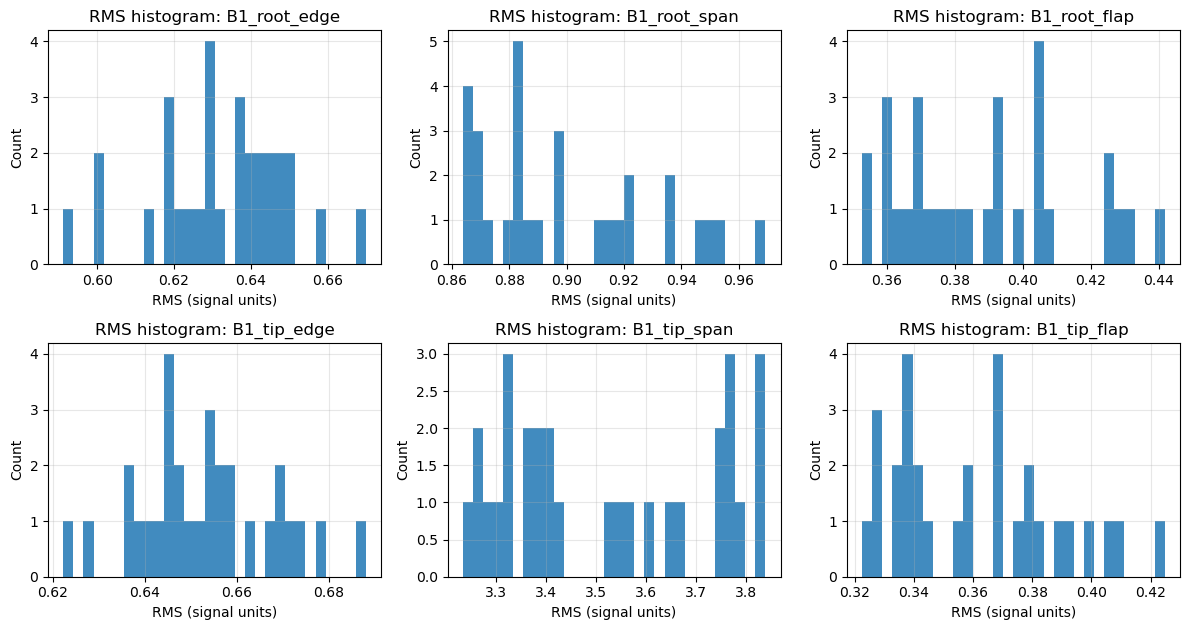

In [51]:
# CONFIG
fs = 62.5                 # sampling frequency [Hz]
window_sec = 20         # window length [s]
cols = ['B1_root_edge', 'B1_root_span', 'B1_root_flap', 'B1_tip_edge',
       'B1_tip_span', 'B1_tip_flap' ] # edit as needed
time_col = 't'        # set to None if you don't have timestamps


# STATS PER WINDOW

def compute_window_stats(df, cols, fs, window_sec, time_col=None):
    win = int(window_sec * fs)
    n = len(df)
    windows = [(i, i+win) for i in range(0, n - win + 1, win)]  # non-overlapping

    rows = []
    for w_idx, (i0, i1) in enumerate(windows, start=1):
        w = df.iloc[i0:i1]
        row = {'window': w_idx,
               'window_start_idx': i0,
               'window_end_idx': i1-1}
        if time_col and time_col in df.columns:
            row['window_start_time'] = w[time_col].iloc[0]
            row['window_end_time']   = w[time_col].iloc[-1]
        for c in cols:
            x = w[c].to_numpy(dtype=float)
            row[f'{c}_mean'] = np.nanmean(x)
            row[f'{c}_rms']  = float(np.sqrt(np.nanmean(x**2)))
            row[f'{c}_std']  = np.nanstd(x)
            row[f'{c}_min']  = np.nanmin(x)
            row[f'{c}_max']  = np.nanmax(x)
        rows.append(row)
    return pd.DataFrame(rows)

stats = compute_window_stats(T1, cols, fs, window_sec, time_col=time_col)

x = pd.to_datetime(stats['window_start_time'], errors='coerce')
x_label = 'Window start time'

# LINE PLOTS: MEAN & RMS OVER TIME

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
for c in cols:
    axes[0].plot(x, stats[f'{c}_mean'], label=c, alpha=0.9)
axes[0].set_title(f'Mean per {window_sec}s window')
axes[0].set_ylabel('Mean (signal units)')
axes[0].grid(True, alpha=0.3)
axes[0].legend(ncol=min(3, len(cols)))

for c in cols:
    axes[1].plot(x, stats[f'{c}_rms'], label=c, alpha=0.9)
axes[1].set_title(f'RMS per {window_sec}s window')
axes[1].set_xlabel(x_label)
axes[1].set_ylabel('RMS (signal units)')
axes[1].grid(True, alpha=0.3)
plt.tight_layout()


# BAR CHART: AVERAGE PEAK-TO-PEAK RANGE (max - min)

avg_range = {}
for c in cols:
    p2p = stats[f'{c}_max'] - stats[f'{c}_min']
    avg_range[c] = float(np.nanmean(p2p))

plt.figure(figsize=(10,4))
plt.bar(list(avg_range.keys()), list(avg_range.values()))
plt.title(f'Average peak-to-peak (max–min) per channel (over {window_sec}s windows)')
plt.ylabel('Average peak-to-peak (signal units)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()


# HISTOGRAMS: RMS DISTRIBUTIONS

n_cols = min(3, len(cols))
n_rows = int(np.ceil(len(cols) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3.2*n_rows))
axes = np.atleast_1d(axes).ravel()

for ax, c in zip(axes, cols):
    ax.hist(stats[f'{c}_rms'].dropna(), bins=30, alpha=0.85)
    ax.set_title(f'RMS histogram: {c}')
    ax.set_xlabel('RMS (signal units)')
    ax.set_ylabel('Count')
    ax.grid(True, alpha=0.3)

for ax in axes[len(cols):]:
    ax.axis('off')
plt.tight_layout()
plt.show()


## Turbine 2

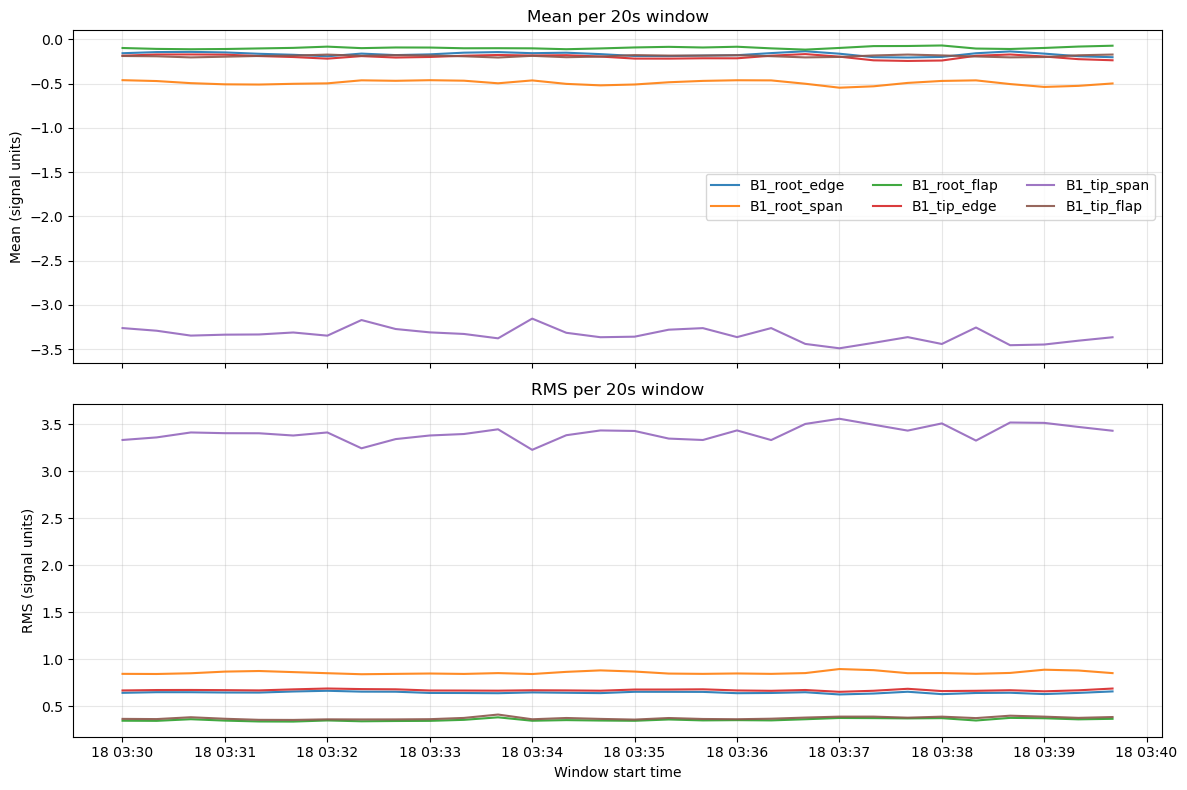

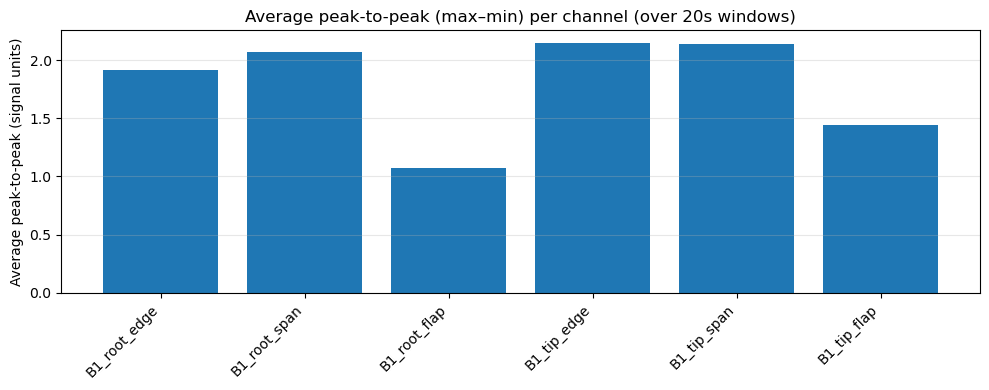

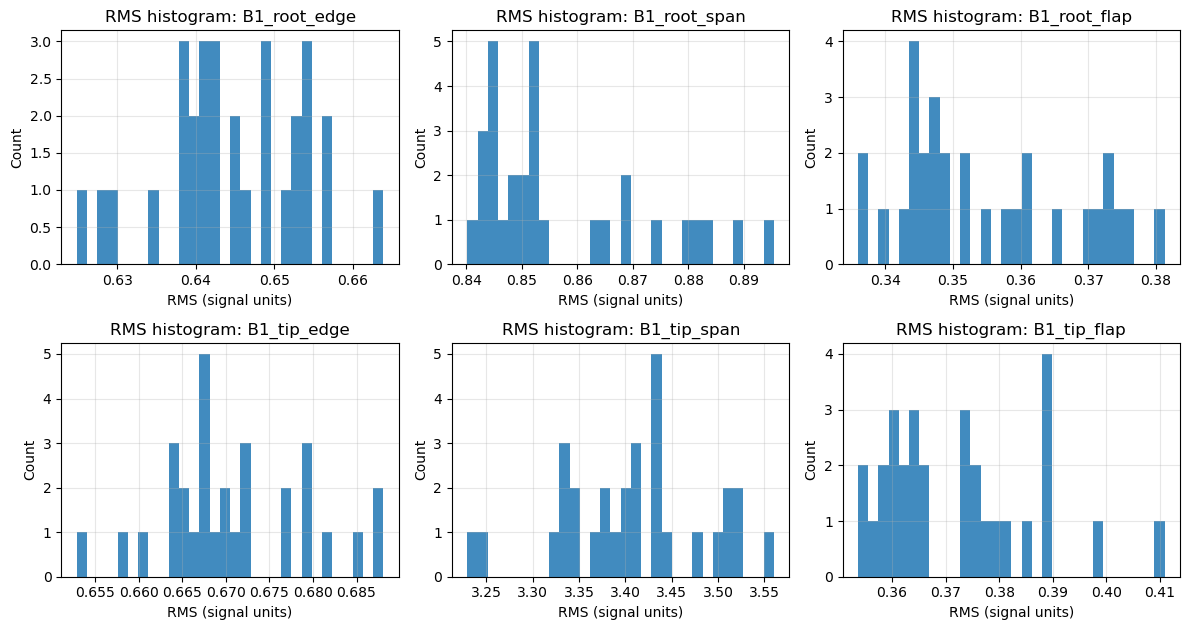

In [53]:
# CONFIG
fs = 62.5                 # sampling frequency [Hz]
window_sec = 20         # window length [s]
cols = ['B1_root_edge', 'B1_root_span', 'B1_root_flap', 'B1_tip_edge',
       'B1_tip_span', 'B1_tip_flap' ] # edit as needed
time_col = 't'        # set to None if you don't have timestamps


# STATS PER WINDOW

def compute_window_stats(df, cols, fs, window_sec, time_col=None):
    win = int(window_sec * fs)
    n = len(df)
    windows = [(i, i+win) for i in range(0, n - win + 1, win)]  # non-overlapping

    rows = []
    for w_idx, (i0, i1) in enumerate(windows, start=1):
        w = df.iloc[i0:i1]
        row = {'window': w_idx,
               'window_start_idx': i0,
               'window_end_idx': i1-1}
        if time_col and time_col in df.columns:
            row['window_start_time'] = w[time_col].iloc[0]
            row['window_end_time']   = w[time_col].iloc[-1]
        for c in cols:
            x = w[c].to_numpy(dtype=float)
            row[f'{c}_mean'] = np.nanmean(x)
            row[f'{c}_rms']  = float(np.sqrt(np.nanmean(x**2)))
            row[f'{c}_std']  = np.nanstd(x)
            row[f'{c}_min']  = np.nanmin(x)
            row[f'{c}_max']  = np.nanmax(x)
        rows.append(row)
    return pd.DataFrame(rows)

stats = compute_window_stats(T2, cols, fs, window_sec, time_col=time_col)

x = pd.to_datetime(stats['window_start_time'], errors='coerce')
x_label = 'Window start time'

# LINE PLOTS: MEAN & RMS OVER TIME

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
for c in cols:
    axes[0].plot(x, stats[f'{c}_mean'], label=c, alpha=0.9)
axes[0].set_title(f'Mean per {window_sec}s window')
axes[0].set_ylabel('Mean (signal units)')
axes[0].grid(True, alpha=0.3)
axes[0].legend(ncol=min(3, len(cols)))

for c in cols:
    axes[1].plot(x, stats[f'{c}_rms'], label=c, alpha=0.9)
axes[1].set_title(f'RMS per {window_sec}s window')
axes[1].set_xlabel(x_label)
axes[1].set_ylabel('RMS (signal units)')
axes[1].grid(True, alpha=0.3)
plt.tight_layout()


# BAR CHART: AVERAGE PEAK-TO-PEAK RANGE (max - min)

avg_range = {}
for c in cols:
    p2p = stats[f'{c}_max'] - stats[f'{c}_min']
    avg_range[c] = float(np.nanmean(p2p))

plt.figure(figsize=(10,4))
plt.bar(list(avg_range.keys()), list(avg_range.values()))
plt.title(f'Average peak-to-peak (max–min) per channel (over {window_sec}s windows)')
plt.ylabel('Average peak-to-peak (signal units)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()


# HISTOGRAMS: RMS DISTRIBUTIONS

n_cols = min(3, len(cols))
n_rows = int(np.ceil(len(cols) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3.2*n_rows))
axes = np.atleast_1d(axes).ravel()

for ax, c in zip(axes, cols):
    ax.hist(stats[f'{c}_rms'].dropna(), bins=30, alpha=0.85)
    ax.set_title(f'RMS histogram: {c}')
    ax.set_xlabel('RMS (signal units)')
    ax.set_ylabel('Count')
    ax.grid(True, alpha=0.3)

for ax in axes[len(cols):]:
    ax.axis('off')
plt.tight_layout()
plt.show()
